# 모듈 임포트

In [1]:
import pandas as pd
import numpy as np
import torch
import tensorflow as tf
import random
import torch.optim as optim
from torch.optim import AdamW
from torch import nn
from torch.utils.data import DataLoader, Dataset,TensorDataset
from torch.nn import functional as F
import re
import urllib.request
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from konlpy.tag import Mecab
import wandb
import collections
import pickle
import kss
from gensim.summarization.summarizer import summarize
from transformers import set_seed

from ktextaug import TextAugmentation
import ktextaug

import os
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel, AutoModelForMaskedLM
from transformers import GPT2Config, GPT2Tokenizer, GPT2LMHeadModel

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'NanumGothic'

random_seed = 42
random.seed(random_seed)
set_seed(random_seed)
np.random.seed(random_seed)
os.environ["PYTHONHASHSEED"] = str(random_seed)
tf.random.set_seed(random_seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(random_seed)
if device == 'cuda':
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
wandb.login()

# 1. 데이터 불러오기

In [4]:
def load_data(file_name):#파일이름만 넣기
    data_path = os.getenv('HOME') + '/aiffel/project/FnGuide/data/ad_news'#경로는 자신의 경로로 바꿔서 하면 됨
    file_path = os.path.join(data_path, file_name)
    df = pd.read_csv(file_path, encoding='utf-8', delimiter='\t')
    return df

## 1-1 사전학습 모델 및 토크나이저 불러오기

In [5]:
model_name = "klue/roberta-base"  # 허깅페이스에서 모델만 갈아끼우면 됨

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # 예측하고자 하는 클래스의 수를 넣어줘야함
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier

In [4]:
# kb-albert-char-base-v2, kfdeberta-base
model_name='kfdeberta-base'

p_model_path = os.getenv('HOME') + "/aiffel/project/FnGuide/kfdeberta-base"

model = AutoModelForSequenceClassification.from_pretrained(p_model_path, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(p_model_path)


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /aiffel/aiffel/project/FnGuide/kfdeberta-base and are newly initialized: ['pooler.dense.bias', 'classifier.bias', 'classifier.weight', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.to(device)

# 3. 3-1Data load

In [7]:
train_df = load_data('preprocess_train.csv')
val_df = load_data('preprocess_val.csv')
test_df = load_data('preprocess_test.csv')

### 3-1-1. Back translate

In [8]:
def back_translate(data: pd.DataFrame, label: int, num: int, mode: str="back_translate", target_language: str='en', prob: int=0.4)-> pd.DataFrame:
    """
        Input:
            data (pandas.DataFrame) : CSV 파일로 구성된 데이터
            label (int) : 증강에 사용할 레이블
            num (int) : 증강 개수
            mode (str, optional) : 데이터 증강 모드. (back_translate/noise_add), 기본값은 "back_translate"
            target_language (str, optional) : 번역할 언어. 기본값은 'en' (영어)
            prob (float, optional) : noise_add 모드에서의 적용 확률
        
        Returns:
            augmented_df (pd.DataFrame) : 증강된 데이터들로 구성된 DataFrame  
    """
    
    # TextAugmentation 객체 생성
    agent = TextAugmentation(tokenizer="mecab", num_processes=1)

    # 선택한 레이블로 데이터 필터링
    filtered_data = data[data['label'] == label]['document'].tolist()

    # 데이터 증강
    augmented_data = []
    selected_data_set = set()  # 중복 선택된 데이터를 추적하기 위한 집합

    for _ in range(num):
        selected_data = random.choice(filtered_data)  # 원본 데이터 중에서 무작위로 선택

        while selected_data in selected_data_set:
            selected_data = random.choice(filtered_data)  # 중복된 데이터가 선택되면 다시 선택

        selected_data_set.add(selected_data)  # 선택된 데이터를 집합에 추가

        # 데이터 증강
        if mode == "noise_add":
            generated_data = agent.generate(selected_data, mode="noise_add", prob=prob, noise_mode=['phonological_change', 'vowel_change', 'jamo_split'])
        else:
            generated_data = agent.generate(selected_data, mode="back_translate", target_language=target_language)  #일본어로 하려면 target_language='jp'
        
        augmented_data.append(generated_data)

    # 생성된 데이터를 DataFrame으로 변환
    augmented_df = pd.DataFrame({'document': augmented_data, 'label': label})
    
    return augmented_df

### 3-1-2. Document Mixing

In [9]:
min_blocks = 2

In [10]:
def tokenize_sentences(text: str, mode: str ='kss') -> list :
    """
    문장을 분리하는 함수
    
    Input:
        text (str): 증강할 문장
        mode (str): 문장을 분리하는 방식

    Output:
        sentences(list): 분리된 문장 리스트
    """
    if mode == 'to':
        sentences = tokenizer.tokenize(text)  # 토크나이저를 사용하여 문장 단위로 분리

    else:
        sentences = kss.split_sentences(text)  # Split sentences using kss library

    return sentences

In [11]:
def sentence_shuffle(text: str, min_blocks: int = min_blocks) -> str:
    """
    하나의 문장내에서 문장 순서를 뒤섞는 함수
    
    Input:
        text (str): 증강할 문장
        min_blocks (str): 최소 문장 수

    Output:
        augmented_text (str): 셔플된 하나의 텍스트
    """
    sentences = tokenize_sentences(text, 'kss') 
    
    # 분리된 문장들 중에서 하나 이상의 문장 블록을 선택하기 위해 최소 블록 개수를 설정
    min_blocks = min(min_blocks, len(sentences))
    
    # 무작위로 두 개 이상의 문장 블록을 선택
    num_blocks_to_shuffle = random.randint(min_blocks, len(sentences)) #min_blocks부터 len(sentences) 사이의 정수 에서 무작위로 하나의 정수를 반환하는 함수
    selected_blocks_indices = random.sample(range(len(sentences)), num_blocks_to_shuffle)
    
    # 선택된 문장 블록들의 위치를 서로 바꿈
    shuffled_sentences = [sentences[i] for i in range(len(sentences)) if i not in selected_blocks_indices]
    for i in selected_blocks_indices:
        shuffled_sentences.append(sentences[i])
    
    # 문장 블록들을 다시 하나의 문자열로 합쳐서 증강된 문장을 생성
    augmented_text = ' '.join(shuffled_sentences)
    
    return augmented_text.strip()

In [12]:
def mix_document(data, label, num, min_blocks = min_blocks, mix_ratio_range=(0.2, 0.4), mode='kss', shuffle_mode=2)->pd.DataFrame:
    """
        Input:
            data (pandas.DataFrame) : CSV 파일로 구성된 데이터
            label (int) : 증강에 사용할 레이블
            num (int) : 증강 개수
            min_blocks (str): 최소 문장 수
            mix_ratio_range (tuple) : 데이터에서 사용할 문장 선택 비율, 기본값 0.2~0.4에서 랜덤
            mode (str, optional) : 데이터 증강 모드. (kss/tokenize), 기본값은 "back_translate"
            shuffle_mode (int) : 문장 mix할 개수, (1,2), 기본값은 2
        
        Returns:
            augmented_df (pd.DataFrame) : 증강된 데이터들로 구성된 DataFrame  
    """
    augmented_data = []
    filtered_data = data[data['label'] == label]['document'].tolist()
    
    selected_data_set = set()  # 중복 선택된 쌍을 추적하기 위한 집합
    
    for _ in range(num):
        
        if shuffle_mode == 2:
        
            selected_data = random.sample(filtered_data, 2)  # 원본 데이터 중에서 2개를 무작위로 선택

            while tuple(selected_data) in selected_data_set:
                selected_data = random.sample(filtered_data, 2)  # 중복된 데이터가 선택되면 다시 선택

            selected_data_set.add(tuple(selected_data))

            sentences_1 = tokenize_sentences(selected_data[0], mode)  # 첫 번째 선택된 데이터의 문장으로 분리
            sentences_2 = tokenize_sentences(selected_data[1], mode)  # 두 번째 선택된 데이터의 문장으로 분리

            mix_ratio_1 = random.uniform(*mix_ratio_range)
            mix_ratio_2 = random.uniform(*mix_ratio_range)

            # sentences_1에서 특정 비율만큼 문장 제거
            num_sentences_to_remove = int(len(sentences_1) * mix_ratio_1)
            removed_sentences = random.sample(sentences_1, num_sentences_to_remove)
            augmented_sentences_1 = [sentence for sentence in sentences_1 if sentence not in removed_sentences]


            # sentences_2에서 특정 비율만큼 문장 추출
            num_sentences_to_extract_2 = int(len(sentences_2) * mix_ratio_2)
            extracted_sentences_2 = random.sample(sentences_2, num_sentences_to_extract_2)

            # 추출된 문장들을 랜덤하게 위치에 삽입하여 augmented_sentences_1에 삽입
            for sentence in extracted_sentences_2:
                random_index = random.randint(0, len(augmented_sentences_1))
                augmented_sentences_1.insert(random_index, sentence)

            if mode == 'to':
                augmented_text = tokenizer.convert_tokens_to_string(augmented_sentences_1)  # 토큰을 다시 문자열로 변환하여 문서로 만듦
            else:
                augmented_text = ' '.join(augmented_sentences_1)  # 문장 내의 단어들을 공백으로 연결하여 문장으로 만듦

            augmented_data.append(augmented_text)
            
        elif shuffle_mode == 1:
        
            selected_data = random.choice(filtered_data)# 원본 데이터 중에서 1개를 무작위로 선택

            while tuple(selected_data) in selected_data_set:
                selected_data = random.choice(filtered_data)  # 중복된 데이터가 선택되면 다시 선택

            selected_data_set.add(tuple(selected_data))

            augmented_text = sentence_shuffle(selected_data, min_blocks)
            augmented_data.append(augmented_text)
        
    # 생성된 증강 데이터에 레이블 1 추가
    augmented_df = pd.DataFrame({'document': augmented_data, 'label': label})
        
    return augmented_df

### 3-1-3. KoEDA

p = (alpha_sr, alpha_ri, alpha_rs, prob_rd)

In [13]:
from koeda import EDA

def ag_koeda(data: pd.DataFrame, label: int, num: int, p: tuple=(0.3, 0.3, 0.3, 0.3))-> pd.DataFrame:
    """
    Input:
        data (DataFrame): 증강시킬 데이터가 있는 데이터 프레임
        label (int): 증강시키고 싶은 label
        num (int): 증강시킬 데이터의 수
        p (tuple): alpha_sr, alpha_ri, alpha_rs, prob_rd 기법의 수치
        
    Output:
        augmented_df (DataFrame): 증강시킨 데이터가 있는 데이터 프레임
    """
    
    eda = EDA(morpheme_analyzer="Mecab", alpha_sr=p[0], alpha_ri=p[1], alpha_rs=p[2], prob_rd=p[3])

    # 데이터 필터링
    filtered_data = data[data['label'] == label]['document'].tolist()
    
    selected_data_set = set()  # 중복 선택된 데이터를 추적하기 위한 집합

    # 데이터 증강
    augmented_data = []
    for _ in range(num):
        selected_data = random.choice(filtered_data)  # 원본 데이터 중에서 무작위로 선택

        while selected_data in selected_data_set:
            selected_data = random.choice(filtered_data)  # 중복된 데이터가 선택되면 다시 선택

        selected_data_set.add(selected_data)  # 선택된 데이터를 집합에 추가

        # 데이터 증강
        generated_data = eda(selected_data, p=p, repetition=1)  # repetition: 한 문장을 몇 개로 증강시킬 것인지
        augmented_data.append(generated_data)

    # 생성된 데이터를 DataFrame으로 변환
    augmented_df = pd.DataFrame({'document': augmented_data, 'label': label})

    return augmented_df

### 3-1-4. Fill Masked Model

In [14]:
def fill_masked_augmentation(df: pd.DataFrame, label_num: int, random_number: int, num_masks_ratio: float) -> pd.DataFrame:
    """
    Input:
        df (DataFrame): 증강시킬 데이터가 있는 데이터 프레임
        label_num (int): 증강시키고 싶은 label number
        random_number (int): 증강시킬 데이터의 수
        num_masks_ratio (float): 본문에서 마스킹 시킬 비율
        max_length (int): sentence 토큰의 최대 길이
        
    Output:
        aug_data (DataFrame): 증강시킨 데이터가 있는 데이터 프레임
    """
    
    label_data = df[df['label'] == label_num]
    predicted_tokens_list = []
    fill_model.to(device)
    random.seed(random_seed) #이렇게 하니까 증강문이 고정됨(마스킹도 고정)
    
    for _ in tqdm(range(random_number)):
        
        random_sentences = random.choice(label_data['document'].tolist()) 

        num_masks = int(len(random_sentences.split()) * num_masks_ratio)
        num_masks = min(num_masks, 20)
        words = random_sentences.split()
        masked_indices = random.sample(range(len(words)), num_masks)
        masked_text = ' '.join('[MASK]' if i in masked_indices else word for i, word in enumerate(words))
        tokenized_sentence = fill_tokenizer.tokenize(masked_text)
        masked_indices = [i for i, token in enumerate(tokenized_sentence) if token == fill_tokenizer.mask_token]
        
        predicted_tokens = []
        for index in masked_indices:
            tokens = tokenized_sentence.copy()
            tokens[index] = fill_tokenizer.mask_token
            input_ids = fill_tokenizer.convert_tokens_to_ids(tokens)
            inputs = torch.tensor([input_ids]).to(device)

            with torch.no_grad():
                outputs = fill_model(inputs)
                predictions = outputs.logits[0, index].topk(k=5)
            
            max_count = 5
            count = 0
            random_prediction_index = torch.multinomial(predictions.values, 1)  # 상위 5개 중에서 랜덤하게 하나 선택
            random_prediction_token_id = predictions.indices[random_prediction_index].item()  # 선택한 토큰 ID 추출
            random_prediction_token = fill_tokenizer.convert_ids_to_tokens([random_prediction_token_id])[0]  # 토큰으로 변환
            
            while random_prediction_token in ["(",")"," ",".", ",", "'", '"',"‘","’",'“','”',"[SEP]", "[PAD]", "[UNK]"]:
                count += 1
                if count >= max_count:
                    random_prediction_token = " "
                    break
                random_prediction_index = torch.multinomial(predictions.values, 1)  # 상위 5개 중에서 랜덤하게 하나 선택
                random_prediction_token_id = predictions.indices[random_prediction_index].item()  # 선택한 토큰 ID 추출
                random_prediction_token = fill_tokenizer.convert_ids_to_tokens([random_prediction_token_id])[0]  # 토큰으로 변환
                
            predicted_tokens.append(random_prediction_token)

        new_sentence = tokenized_sentence.copy()

        for index, predicted_token in zip(masked_indices, predicted_tokens):
            new_sentence[index] = predicted_token

        new_sentence = fill_tokenizer.convert_tokens_to_string(new_sentence).strip()
        predicted_tokens_list.append(new_sentence)

    aug_data = pd.DataFrame({'document': predicted_tokens_list, 'label': label_num})

    return aug_data

### 3-1-5. Summarize sentences
#### 3-1-5-1. 추출적 요약

In [7]:
def summarize_function(text: str, summarize_ratio: float) -> str:
    '''
    텍스트를 요약시키는 함수
    
    Input:
        text (str): 요약시킬 텍스트
        summarize_ratio (float): 요약 비율
       
    Output:
        summraize_text (str): 요약된 텍스트    
    '''
    summraize_text = summarize(text, ratio = summarize_ratio)
    summraize_text = summraize_text.replace('\n', ' ')
    
    return summraize_text

In [8]:
def text_summarize(df: pd.DataFrame) -> pd.DataFrame:
    '''
    임베딩된 텍스트의 길이가 512가 넘으면 텍스트를 요약하여 요약된 데이터를 이용한 데이터프레임을 만드는 함수
    
    Input:
        df (DataFrame): 요약시킬 데이터가 있는 데이터프레임
       
    Output:
        augmented_df (DataFrame): 요약된 텍스트가 있는 데이터프레임  
    '''
    
    summarize_data = []
    labels = []
    index = []
    for i in tqdm(range(len(df))):
        if 512 < len(tokenizer.encode(df['document'][i])):
            aa = summarize_function(df['document'][i], 0.5)
            summarize_data.append(aa)
            labels.append(df['label'][i])
            index.append(i)
    augmented_df = pd.DataFrame({'document': summarize_data, 'label': labels, 'index': index})
    
    return augmented_df

#### 3-1-5-2. 추상적 요약

In [11]:
from transformers import BartForConditionalGeneration, PreTrainedTokenizerFast

class KoBARTConditionalGeneration(torch.nn.Module):
    def __init__(self):
        super(KoBARTConditionalGeneration, self).__init__()
        self.model = BartForConditionalGeneration.from_pretrained('gogamza/kobart-base-v2')
        self.tokenizer = PreTrainedTokenizerFast.from_pretrained('gogamza/kobart-base-v2')
        self.pad_token_id = self.tokenizer.pad_token_id

    def forward(self, inputs):
        attention_mask = inputs['input_ids'].ne(self.pad_token_id).float()
        decoder_attention_mask = inputs['decoder_input_ids'].ne(self.pad_token_id).float()

        return self.model(input_ids=inputs['input_ids'],
                          attention_mask=attention_mask,
                          decoder_input_ids=inputs['decoder_input_ids'],
                          decoder_attention_mask=decoder_attention_mask,
                          labels=inputs['labels'], return_dict=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = KoBARTConditionalGeneration().to(device)
tokenizer = PreTrainedTokenizerFast.from_pretrained('gogamza/kobart-base-v2')

Downloading:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/473M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/666k [00:00<?, ?B/s]

In [ ]:
# 모델 인스턴스 생성
model_wrapper = KoBARTConditionalGeneration().to(device)

# 가중치 로드
model_path_gen = os.getenv('HOME') + "/aiffel/project/FnGuide/model/best_model.pt"
model_wrapper.load_state_dict(torch.load(model_path_gen))

# 모델을 평가 모드로 설정
model_wrapper.eval()

In [13]:
def group_sentences(sentences, ratio):
    num_groups = len(sentences) // ratio
    grouped_sentences = [''.join(sentences[i : i + ratio]) for i in range(0, len(sentences), ratio)]
    return grouped_sentences

In [10]:
# 토큰기준 512넘어가는 데이터 레이블 리스트

file_name = '512_over_text_index.txt'

with open(file_name, 'r') as file:
    list_str = file.read()

gen_index_list = [int(item) for item in list_str.split(',')]

In [11]:
train_df['document'][gen_index_list[233]]

'삼성은 삼성전자와 계열사 임직원의 글로벌 역량을 총동원해 2030 부산세계박람회 유치 활동에 나서고 . 부산엑스포 유치를 위해 대한민국 대표 기업으로서 솔선수범한다는 자세로 총력전을 펼친다는 계획이다 . 임직원 세계 돌며 유치 홍보삼성전자는 주요 경영진을 주축으로 세계박람회기구 회원국 관계자들을 직접 만나 유치 활동을 지원하고 . 한종희 삼성전자 디바이스경험부문장은 최근 스웨덴 , 남아프리카공화국 등을 방문해 현지 사업을 점검하고 정부 관계자들을 만나 부산엑스포 지지를 요청했다 . 8월 15일엔 스웨덴 스톡홀름에서 안나 할베리 통상장관을 접견해 스웨덴 정부의 주요 관심사인 순환 경제 녹색 전환 대해 논의했다 . 같은 달 11일에는 남아프리카공화국 프리토리아에서 이브라힘 파텔 통상산업부 장관과 날레디 판도르 국제협력부 장관을 만났다 . 노태문 모바일경험사업부장은 8월 5일 베트남 하노이에서 팜 민 찐 베트남 총리를 접견해 부산엑스포 지지를 요청했다 . 16일에는 파나마 파나마시티에서 삼성전자 청소년 기술교육 프로그램인 삼성이노베이션캠퍼스 행사에 참석해 야스민 콜론 데 코르티소 영부인 , 페데리코 알파로 보이드 통상산업부 장관을 접견했다 . 이재승 생활가전사업부장은 엘살바도르 , 코스타리카 , 도미니카공화국 중남미 3개국을 방문해 현지 사업 현황을 점검하고 각국 관계자를 만나 부산엑스포 유치 지지를 요청했다 . 이인용 cr담당 사장은 8월 19일 동티모르 딜리에서 조제 하무스 오르타 동티모르 대통령과 타우르 마탄 루아크 총리를 만나 삼성전자의 혁신 기술 사례와 사회공헌 활동을 설명하고 부산엑스포 협력을 요청했다 . 국가 간 주요 행사에 맞춰 부산엑스포 유치 활동을 알리기도 했다 . 박학규 경영지원실장은 7월 피지 수바에서 열린 태평양도서국포럼 정상회의 맞아 현지에서 참가국 관계자들과 면담하고 삼성전자의 혁신 기술 사례와 사회공헌 활동을 설명하며 태평양 도서국들의 부산엑스포 유치 협력을 당부했다 . 해외 곳곳 옥외광고 홍보도삼성전자는 이와 해외 주요 장소에 부산엑

In [15]:
def gen_text(df: pd.DataFrame, gen_index_list : list) -> pd.DataFrame:
    summarize_data = []
    labels = []
    index = []

    for j in tqdm(range(len(gen_index_list))):
        i = gen_index_list[j]
        sentence = df['document'][i]
        text = tokenize_sentences(sentence)
        ratio = len(text) // 5
        t_text = group_sentences(text, ratio)

        p_text = []
        for text in t_text:
            input_ids = tokenizer.encode(text)
            input_ids = torch.tensor(input_ids)
            input_ids = input_ids.unsqueeze(0).to(device)
            output = model_wrapper.model.generate(input_ids, eos_token_id=1, max_length=256, num_beams=10)
            output = tokenizer.decode(output[0], skip_special_tokens=True)
            p_text.append(output)

        gen_text = ' '.join(p_text)
        summarize_data.append(gen_text)
        labels.append(df['label'][i])
        index.append(i)
            
    augmented_df = pd.DataFrame({'document': summarize_data, 'label': labels, 'index': index})
    
    return augmented_df

In [ ]:
gen_aug = gen_text(train_df, gen_index_list)

In [ ]:
# 증강된것 저장
gen_aug.to_csv(os.getenv('HOME') + '/aiffel/project/FnGuide/data/ad_news/gen_train.csv', index=False, encoding='utf-8', sep='\t')

In [ ]:
gen_train = pd.read_csv(os.getenv('HOME') + '/aiffel/project/FnGuide/data/ad_news/summarized_train.csv', sep='\t')
gen_train = gen_train[['document', 'label']] #이거 하고 해야 오류 안남

In [ ]:
#1. 증강된 것 포함해서 실험 진행
gen_data = pd.concat([train_df, gen_train]).reset_index(drop=True)

In [ ]:
#2. 증강된 것 대체해서 실험 진행
index_list = gen_train.index.tolist()

for i in gen_train['index']:
    for j in index_list:
        if i == j:
            train_df['document'][j] = gen_train['document'][i]

## 3-2. 클래스 및 함수 만들기

In [15]:
class TrainTestDataset(Dataset):
    def __init__(self, dataframe, transform=True, train=True):
        self.data = dataframe
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if self.train:  # train data이면 sentence와 label 같이 전처리
            labels = self.data['label'][index]
            sentence = self.data['document'][index]
        else:  # test data이면 label만 같이 전처리
            sentence = self.data['document'][index]

        encoded_dict = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=config.MAX_LEN,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
#             return_token_type_ids=True
        )

        padded_token_list = encoded_dict['input_ids'][0]
        token_type_id = encoded_dict['token_type_ids'][0]
        att_mask = encoded_dict['attention_mask'][0]

        if self.train:
            target = torch.tensor(labels)
            sample = (padded_token_list, token_type_id, att_mask, target)
        else:
            sample = (padded_token_list, token_type_id, att_mask)

        return sample

In [16]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=3, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [17]:
def softmax_check(diff_indices, new_df):
    for i in diff_indices:
        print("인덱스:", i)
        print("Real news(%) : ", new_df['probability_negative'][i])
        print("AD news(%) : ", new_df['probability_positive'][i])
        print('실제 답변:{}, 예측 답변:{}'.format(new_df['label'][i],new_df['predicted_label'][i]))
        print('\n')

# 4. 실험 

#### 1. Back trans

In [21]:
augmented_df = back_translate(data=train_df, label=1, num=1000, mode="back_translate", target_language='en')
train_back = pd.concat([train_df, augmented_df], ignore_index=True)

#### 2. mix document
##### 2-1 문장 2개 mix

In [22]:
augmented_df_1 = mix_document(data=train_df, label=1, num=1000, min_blocks = min_blocks, mix_ratio_range=(0.2, 0.4), mode='kss', shuffle_mode=2)
train_mix_1 = pd.concat([train_df, augmented_df_1], ignore_index=True)

[Kss]: Oh! You have mecab in your environment. Kss will take this as a backend! :D



##### 2-2 문장 1개 mix

In [23]:
augmented_df_2 = mix_document(data=train_df, label=1, num=1000, min_blocks = min_blocks, mix_ratio_range=(0.2, 0.4), mode='kss', shuffle_mode=1)
train_mix_2 = pd.concat([train_df, augmented_df_2], ignore_index=True)

##### 2-3 문장 2개 + 1개 혼합

In [24]:
augmented_df_3_1 = mix_document(data=train_df, label=1, num=500, min_blocks = min_blocks, mix_ratio_range=(0.2, 0.4), mode='kss', shuffle_mode=2)
augmented_df_3_2 = mix_document(data=train_df, label=1, num=500, min_blocks = min_blocks, mix_ratio_range=(0.2, 0.4), mode='kss', shuffle_mode=1)

train_mix_3 = pd.concat([train_df, augmented_df_3_1, augmented_df_3_2], ignore_index=True)

#### 3. KoEDA

In [25]:
augmented_df = ag_koeda(data=train_df, label=1, num=1000, p=(0.2, 0.1, 0.3, 0.1))
train_koeda = pd.concat([train_df, augmented_df], ignore_index=True)

#### 4. Fill masked

In [ ]:
fill_model_name = "monologg/kobigbird-bert-base"  # 허깅페이스에서 모델만 갈아끼우면 됨
fill_model = AutoModelForMaskedLM.from_pretrained(fill_model_name)
fill_tokenizer = AutoTokenizer.from_pretrained(fill_model_name)

In [27]:
augmented_df = fill_masked_augmentation(train_df, label_num = 1, random_number = 1000, num_masks_ratio = 0.15)
train_fill = pd.concat([train_df, augmented_df], ignore_index=True)

100%|██████████| 1000/1000 [10:50<00:00,  1.54it/s]


## 실험(원하는 증강법 데이터를 적용시켜서 학습)
#### ex) Back translation

In [28]:
#wandb 기록용
hyperparameters={
    "model": "klue/roberta-base",
    "data_ag_method" : "back_trans",
    "Stopword" : "True",    
    "MAX_LEN" : 512,
    "epochs" : 3,
    "BATCH_SIZE" : 8,
    'NUM_CORES': 0,
    'learning_rate': 2e-5,
    'eps' : 1e-8,
    'loss' : 'cross_entropy'
      }

#wandb 초기화
wandb.init(project='fn_guide_project',name='AD_NEWS_klue/roberta-base', config = hyperparameters)
config = wandb.config

train_dataset = TrainTestDataset(train_back, train=True)
val_dataset = TrainTestDataset(val_df, train=True)
test_dataset = TrainTestDataset(test_df, train=False)

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                                batch_size=config.BATCH_SIZE,
                                                shuffle=True,
                                                num_workers=config.NUM_CORES)

val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                                batch_size=config.BATCH_SIZE,
                                                shuffle=False,
                                                num_workers=config.NUM_CORES)

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                                batch_size=config.BATCH_SIZE,
                                                shuffle=False,
                                                num_workers=config.NUM_CORES)

model.to(device)
optimizer = AdamW(model.parameters(), lr=config.learning_rate, eps =config.eps)

wandb: Currently logged in as: sungwo101 (fn_guide_project). Use `wandb login --relogin` to force relogin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [29]:
import wandb
import random
from sklearn.metrics import f1_score, precision_score, recall_score

output = os.getenv('HOME')+'/aiffel/project/FnGuide/model/' #자신의 경로로 바꾸기
model_name1 = model_name.replace('/','_')

folder_name = f"{model_name1}_{config.data_ag_method}_{config.loss}"
model_save_folder = os.path.join(output, folder_name)
os.makedirs(model_save_folder, exist_ok=True)  # 폴더가 없으면 생성

early_stopping = EarlyStopping(patience=3, verbose=True, path=os.path.join(model_save_folder, f'{model_name1}_{config.data_ag_method}_{config.loss}_stopword_classification_model.pt'))

losses = []
accuracies = []
f1_scores = []

model.train()

wandb.watch(model,log="all",log_freq=20)  #model: 모니터링할 모델 객체/log:기록할 항목을 지정하는 옵션/log_freq:기록 빈도

# loss_fn = Balanced_crossentropy_loss(beta=0.3)
# loss_fn = Weighted_crossentropy_loss(pos_weight=3, weight=1)

for i in range(config.epochs):
    total_loss = 0.0
    correct = 0
    total = 0
    y_true_train = []  # 학습 데이터의 실제 라벨을 저장할 리스트
    y_pred_train = []  # 학습 데이터의 예측 라벨을 저장할 리스트

    # Training loop
    for input_ids_batch, token_type_id_batch, attention_masks_batch, y_batch in tqdm(train_dataloader):
        optimizer.zero_grad()
        y_batch = y_batch.to(device)
        input_ids_batch = input_ids_batch.to(device)
        token_type_id_batch = token_type_id_batch.to(device)
        attention_masks_batch = attention_masks_batch.to(device)
        y_pred = model(input_ids_batch, token_type_ids=token_type_id_batch, attention_mask=attention_masks_batch)[0].to(device)
        
#         loss = loss_fn(y_pred, y_batch) #Balanced_crossentropy_loss 사용시
#         loss = loss_function(y_pred, y_batch.view(-1, 1)) #hingeloss 사용시
#         loss = FocalLoss()(y_pred, y_batch) #focalloss 사용시
        loss = F.cross_entropy(y_pred, y_batch)  # cross_entropy 사용시

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(y_pred, 1)
        correct += (predicted == y_batch).sum()
        total += len(y_batch)
        
        # 학습 데이터의 실제 라벨과 예측 라벨을 저장하여 나중에 F1 점수 계산에 사용
        y_true_train.extend(y_batch.tolist())
        y_pred_train.extend(predicted.tolist())

    losses.append(total_loss)
    accuracies.append(correct.float() / total)
    
    f1_train = f1_score(y_true_train, y_pred_train, average='binary')
    precision_train = precision_score(y_true_train, y_pred_train, average='binary')
    recall_train = recall_score(y_true_train, y_pred_train, average='binary')
    f1_scores.append(f1_train)

    y_true_val = []  # 검증 데이터의 실제 라벨을 저장할 리스트 초기화
    y_pred_val = []  # 검증 데이터의 예측 라벨을 저장할 리스트 초기화
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        val_correct = 0
        val_total = 0
        val_loss = 0.0 #추가

        for val_input_ids_batch, val_token_type_id_batch, val_attention_masks_batch, val_y_batch in tqdm(val_dataloader):
            val_y_batch = val_y_batch.to(device)
            val_input_ids_batch = val_input_ids_batch.to(device)
            val_token_type_id_batch = val_token_type_id_batch.to(device)
            val_attention_masks_batch = val_attention_masks_batch.to(device)
            val_y_pred = model(val_input_ids_batch, token_type_ids=val_token_type_id_batch, attention_mask=val_attention_masks_batch)[0].to(device)

            _, val_predicted = torch.max(val_y_pred, 1)
            val_correct += (val_predicted == val_y_batch).sum()
            val_total += len(val_y_batch)
            
            # 검증 데이터의 실제 라벨과 예측 라벨을 저장
            y_true_val.extend(val_y_batch.tolist())
            y_pred_val.extend(val_predicted.tolist())
        
        # 검증 데이터의 F1 점수 계산
        f1_val = f1_score(y_true_val, y_pred_val, average='binary')
        precision_val = precision_score(y_true_val, y_pred_val, average='binary')
        recall_val = recall_score(y_true_val, y_pred_val, average='binary')

        val_accuracy = val_correct.float() / val_total
        val_loss = F.cross_entropy(val_y_pred, val_y_batch)  # validation loss 값 할당
        
        print(f"Epoch {i+1}/{config.epochs}:")
        print("Train Loss:", total_loss / total, "Accuracy:", correct.float() / total, "F1 Score (Train):", f"{f1_train:.4f}")
        print("Train Precision:", f"{precision_train:.4f}", "Train Recall:", f"{recall_train:.4f}")
        print("Validation Accuracy:", val_accuracy, "F1 Score (Validation):", f"{f1_val:.4f}")
        print("Validation Precision:", f"{precision_val:.4f}", "Validation Recall:", f"{recall_val:.4f}")
    
    wandb.log({
        "Train Loss": total_loss / total,
        "Train Accuracy": correct.float() / total,
        "Validation Accuracy": val_accuracy,
        "Train F1 Score": f1_train,
        "Validation F1 Score": f1_val
    })
    model.train()
         
    # Early Stopping 적용
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print(f"Early stopping!! Goog luck!")
        break
        
    # 모델 저장  
    model_save_path = os.path.join(model_save_folder, f'{model_name1}_{config.data_ag_method}_{config.loss}_stopword_classification_model_{i+1}.pt')
    torch.save(model.state_dict(), model_save_path)
    wandb.save(os.path.join(model_save_folder, f'{model_name1}_{config.data_ag_method}_{config.loss}_stopword_classification_model_{i+1}.pt'))  # 모델 wandb에 저장

100%|██████████| 85/85 [00:26<00:00,  3.19it/s]


Epoch 1/3:
Train Loss: 0.01467119010777354 Accuracy: tensor(0.9588, device='cuda:0') F1 Score (Train): 0.9594
Train Precision: 0.9541 Train Recall: 0.9648
Validation Accuracy: tensor(0.9573, device='cuda:0') F1 Score (Validation): 0.9490
Validation Precision: 0.9507 Validation Recall: 0.9474
Validation loss decreased (inf --> 1.030100).  Saving model ...


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
100%|██████████| 85/85 [00:26<00:00,  3.20it/s]


Epoch 2/3:
Train Loss: 0.0071782427284279105 Accuracy: tensor(0.9824, device='cuda:0') F1 Score (Train): 0.9825
Train Precision: 0.9818 Train Recall: 0.9833
Validation Accuracy: tensor(0.9602, device='cuda:0') F1 Score (Validation): 0.9537
Validation Precision: 0.9329 Validation Recall: 0.9754
EarlyStopping counter: 1 out of 3


100%|██████████| 85/85 [00:27<00:00,  3.08it/s]


Epoch 3/3:
Train Loss: 0.004262124366435507 Accuracy: tensor(0.9874, device='cuda:0') F1 Score (Train): 0.9875
Train Precision: 0.9879 Train Recall: 0.9870
Validation Accuracy: tensor(0.9588, device='cuda:0') F1 Score (Validation): 0.9512
Validation Precision: 0.9446 Validation Recall: 0.9579
EarlyStopping counter: 2 out of 3


100%|██████████| 85/85 [00:26<00:00,  3.17it/s]


0.9631811487481591
              precision    recall  f1-score   support

   real_news       0.95      0.99      0.97       389
          AD       0.98      0.93      0.96       290

    accuracy                           0.96       679
   macro avg       0.97      0.96      0.96       679
weighted avg       0.96      0.96      0.96       679



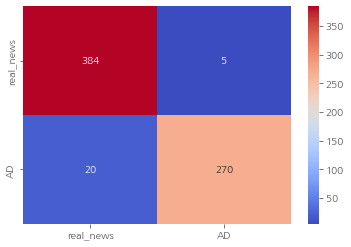

Train Accuracy,▁▇█
Train F1 Score,▁▇█
Train Loss,█▃▁
Validation Accuracy,▁█▄
Validation F1 Score,▁█▄
test_accuracy,▁
Train Accuracy,0.98737
Train F1 Score,0.98747
Train Loss,0.00426
Validation Accuracy,0.95876
Validation F1 Score,0.95122


In [30]:
model.eval()

pred = []
probabilities = [] # 예측 확률값을 저장할 리스트

with torch.no_grad():
    for input_ids_batch, token_type_id_batch, attention_masks_batch in tqdm(test_dataloader):
        y_pred = model(input_ids_batch.to(device),token_type_ids = token_type_id_batch.to(device), attention_mask=attention_masks_batch.to(device))[0]
        _, predicted = torch.max(y_pred, 1)
        pred.extend(predicted.tolist())
        probabilities.extend(F.softmax(y_pred, dim=1).tolist())


    accuracy = accuracy_score(pred, test_df['label'])
    print(accuracy_score(pred, test_df['label']))
    classification_report_str = classification_report(test_df['label'], pred, target_names=['real_news', 'AD'])
    print(classification_report(test_df['label'], pred, target_names=['real_news', 'AD']))

    cm = confusion_matrix(test_df['label'], pred)
    sns.heatmap(cm, annot = True, cmap='coolwarm', xticklabels=['real_news', 'AD'], yticklabels=['real_news', 'AD'], fmt='d')
    plt.show()

    # f1-score 추출
    report = classification_report(test_df['label'], pred, target_names=['real_news', 'AD'], output_dict=True)

    wandb.log({"test_accuracy": accuracy})
    wandb.log({"classification_report": classification_report_str})
    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                                y_true=test_df['label'],
                                                                preds=pred,
                                                                class_names=['negative', 'positive'])})

wandb.finish() #훈련과 평가가 다 끝났을때 해주는 것이 좋음

- 예측 실패 인덱스, softmax값, 맞춘 인덱스 중 softmax 값이 낮은 5개 출력

In [ ]:
test_check_df = test_df.copy() #테스트 데이터프레임 복사
pred1 = pd.Series(pred, name="pred") #예측된 레이블 시리즈로 만들고 이름 붙혀주기
test_check_df = pd.concat([test_check_df, pred1], axis = 1) #두개를 하나의 데이터프레임으로 합치기

diff_indices = test_check_df[test_check_df['label'] != test_check_df['pred']].index #답변이 틀린것들의 index를 뽑을 수 있음

print("예측 실패 인덱스 : ", diff_indices)
#######################################################################################################################################
new_df = test_df.copy()
new_df['predicted_label'] = pred
new_df['probability_negative'] = [prob[0] for prob in probabilities]
new_df['probability_positive'] = [prob[1] for prob in probabilities]

softmax_check(diff_indices, new_df)

negative_lowest_5 = new_df[(new_df['label'] == 0) & (new_df['label'] == new_df['predicted_label'])].nsmallest(5, 'probability_negative').index
positive_lowest_5 = new_df[(new_df['label'] == 1) & (new_df['label'] == new_df['predicted_label'])].nsmallest(5, 'probability_positive').index

print("Label 0일 때 Probability Negative 값이 가장 낮은 5개 인덱스:", negative_lowest_5)
print("Label 1일 때 Probability Positive 값이 가장 낮은 5개 인덱스:", positive_lowest_5)

In [ ]:
"""
예측 실패 인덱스 :  Int64Index([ 40,  71,  73, 158, 161, 188, 192, 244, 246, 275, 291, 303, 324,
            343, 372, 403, 456, 473, 495, 500, 554, 556, 569, 618, 643],
           dtype='int64')

인덱스: 40
Real news(%) :  0.9963169097900391
AD news(%) :  0.0036830061580985785
실제 답변:1, 예측 답변:0


인덱스: 71
Real news(%) :  0.9993676543235779
AD news(%) :  0.0006323348497971892
실제 답변:1, 예측 답변:0

...


Label 0일 때 Probability Negative 값이 가장 낮은 5개 인덱스: Int64Index([505, 439, 395, 536, 385], dtype='int64')
Label 1일 때 Probability Positive 값이 가장 낮은 5개 인덱스: Int64Index([104, 156, 492, 390, 585], dtype='int64')
"""